In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB,  GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import scikitplot as skplt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Lectura del dataset

In [2]:
data= pd.read_csv('train.csv',sep='|')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20104 entries, 0 to 20103
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pregunta   20104 non-null  object
 1   Intencion  20104 non-null  object
dtypes: object(2)
memory usage: 314.2+ KB


In [3]:
data.head()

,Pregunta,Intencion
0,como puedo trabajar en santander rio,Cat_102
1,pagar tarjeta visa querer reintegro,Cat_350
2,pagar tarjeta naranja sistema,Cat_132
3,no se debitó la primera cuota del plan de bien...,Cat_129
4,abonar tarjeta credito,Cat_342


# Preprocesamiento del DF

#### Inicialmente pasamos todo a minuscula y eliminamos todos los signos de puntuación

In [ ]:
## Paso todo a Minuscula
data["Pregunta_new"] = data["Pregunta"]
data["Pregunta_new"] = data["Pregunta_new"].str.lower()
data.head(3)

In [ ]:
# Elimino todos los signos de puntuacion
data["Pregunta_new"] = data["Pregunta_new"].apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

In [ ]:
# Convierto '0800' en una palabra que me indique lo que significa ese valor numerico en especifico
data["Pregunta_new"] = data["Pregunta_new"].apply(lambda x: re.sub('0800', 'servicio_telefonico', x))

In [ ]:
# Convierto los valores numericos a una palabra que me lo indique, ya que no me interesa el valor nominal realmente
data["Pregunta_new"] = data["Pregunta_new"].apply(lambda x: re.sub(r'([0-9]+)', 'number', x))

In [ ]:
data.head(5)

#### Pre-procesamiento se van a depurar todas las oraciones con un diccionario

In [ ]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('Diccionario_propio.csv').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def verification(word): 
    "Most probable spelling correction for word."
    if candidates_verification(word) == 0:
        return
    else:
        return max(candidates_verification(word), key=P)
       
def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def candidates_verification(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or 0)# or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [ ]:
separador = " "

def corregir_frase(frase):
    palabras_corregidas = []
    for p in frase.split():
        palabras_corregidas.append(correction(p))
    return separador.join(palabras_corregidas)
##AA=corregir_frase(data.loc[871,"Pregunta_new"])
##print(AA)
data["Pregunta_corregida",] = data["Pregunta_new"].apply(corregir_frase)

#data.head(10)

In [ ]:
data.to_csv("train_depurado.csv")

## Cargamos el nuevo DataSet

In [4]:
data= pd.read_csv('train_depurado.csv',sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20104 entries, 0 to 20103
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          20104 non-null  int64 
 1   Pregunta            20104 non-null  object
 2   Intencion           20104 non-null  object
 3   Pregunta_new        20104 non-null  object
 4   Pregunta_corregida  20104 non-null  object
dtypes: int64(1), object(4)
memory usage: 785.4+ KB


In [5]:
data.drop(columns="Unnamed: 0",inplace=True)

In [6]:
data.sample(5)

,Pregunta,Intencion,Pregunta_new,Pregunta_corregida
6052,quieronumero telefono comunicarme,Cat_147,quieronumero telefono comunicarme,quieronumero telefono comunicarme
18457,quiero saber el número de mi cuenta no me acuerdo,Cat_68,quiero saber el número de mi cuenta no me acuerdo,quiero saber el número de mi cuenta no me acuerdo
13552,consultar acercar envio tarjeta credito,Cat_293,consultar acercar envio tarjeta credito,consultar acercar envio tarjeta credito
16744,yo tengo tarjeta santander visa universidades....,Cat_334,yo tengo tarjeta santander visa universidades ...,yo tengo tarjeta santander visa universidades ...
16477,por que no me acreditaron los papeles en los q...,Cat_153,por que no me acreditaron los papeles en los q...,por que no me acreditaron los papeles en los q...


# Análisisdel df

In [7]:
a=data['Intencion'].value_counts()

In [8]:
data['Intencion'].unique().size

352

In [9]:
cota = 100
mask_menor10 = a <= cota
print(mask_menor10 == True)

Cat_132    False
Cat_293    False
Cat_1      False
Cat_147    False
Cat_223    False
           ...  
Cat_13      True
Cat_205     True
Cat_11      True
Cat_24      True
Cat_104     True
Name: Intencion, Length: 352, dtype: bool


In [10]:
c = list(a[mask_menor10].keys())

print(c)

['Cat_298', 'Cat_287', 'Cat_301', 'Cat_286', 'Cat_322', 'Cat_246', 'Cat_236', 'Cat_91', 'Cat_36', 'Cat_294', 'Cat_219', 'Cat_239', 'Cat_3', 'Cat_135', 'Cat_292', 'Cat_261', 'Cat_31', 'Cat_157', 'Cat_326', 'Cat_61', 'Cat_172', 'Cat_80', 'Cat_359', 'Cat_304', 'Cat_29', 'Cat_258', 'Cat_103', 'Cat_125', 'Cat_338', 'Cat_345', 'Cat_99', 'Cat_57', 'Cat_32', 'Cat_262', 'Cat_249', 'Cat_357', 'Cat_299', 'Cat_302', 'Cat_93', 'Cat_110', 'Cat_97', 'Cat_283', 'Cat_264', 'Cat_350', 'Cat_181', 'Cat_191', 'Cat_308', 'Cat_178', 'Cat_267', 'Cat_77', 'Cat_270', 'Cat_355', 'Cat_183', 'Cat_297', 'Cat_349', 'Cat_0', 'Cat_218', 'Cat_211', 'Cat_254', 'Cat_282', 'Cat_195', 'Cat_5', 'Cat_243', 'Cat_106', 'Cat_318', 'Cat_320', 'Cat_38', 'Cat_98', 'Cat_175', 'Cat_351', 'Cat_268', 'Cat_323', 'Cat_65', 'Cat_275', 'Cat_102', 'Cat_241', 'Cat_341', 'Cat_49', 'Cat_188', 'Cat_334', 'Cat_193', 'Cat_194', 'Cat_277', 'Cat_143', 'Cat_245', 'Cat_100', 'Cat_306', 'Cat_151', 'Cat_72', 'Cat_44', 'Cat_128', 'Cat_274', 'Cat_114', 

In [11]:
a[mask_menor10].values.sum()

10311

In [12]:
print('Datos perdidos por ser muy pocos como para aprender', round(a[mask_menor10].values.sum() / data.shape[0] * 100, ndigits = 2), '%')

Datos perdidos por ser muy pocos como para aprender 51.29 %


In [13]:
mask_menor=data["Intencion"].apply(lambda x: True if x in c else False)

In [14]:
datos_tirar = data.loc[mask_menor]
prueba = data.drop(datos_tirar.index, axis=0)

In [15]:
prueba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9793 entries, 2 to 20103
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Pregunta            9793 non-null   object
 1   Intencion           9793 non-null   object
 2   Pregunta_new        9793 non-null   object
 3   Pregunta_corregida  9793 non-null   object
dtypes: object(4)
memory usage: 382.5+ KB


In [16]:
data2=prueba

In [17]:
data2['Intencion'].unique().size

32

In [18]:
((data2['Intencion'].unique().size)/(data['Intencion'].unique().size))*100

9.090909090909092

In [19]:
a[:20]

Cat_132    600
Cat_293    567
Cat_1      493
Cat_147    488
Cat_223    477
Cat_39     460
Cat_129    434
Cat_248    434
Cat_303    429
Cat_288    398
Cat_251    378
Cat_225    356
Cat_96     355
Cat_138    354
Cat_342    346
Cat_311    338
Cat_316    312
Cat_337    304
Cat_265    302
Cat_41     275
Name: Intencion, dtype: int64

(array([3., 2., 4., 2., 3., 1., 3., 0., 1., 1.]),
 array([275. , 307.5, 340. , 372.5, 405. , 437.5, 470. , 502.5, 535. ,
        567.5, 600. ]),
 <BarContainer object of 10 artists>)

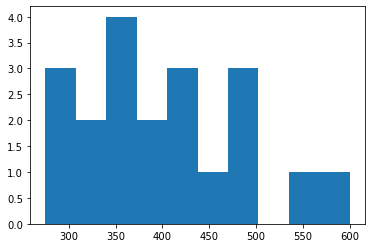

In [20]:
fig = plt.figure()
# creo los axes
ax = plt.axes()
# dibujo en axes:
ax.hist(a[:20], label='', )

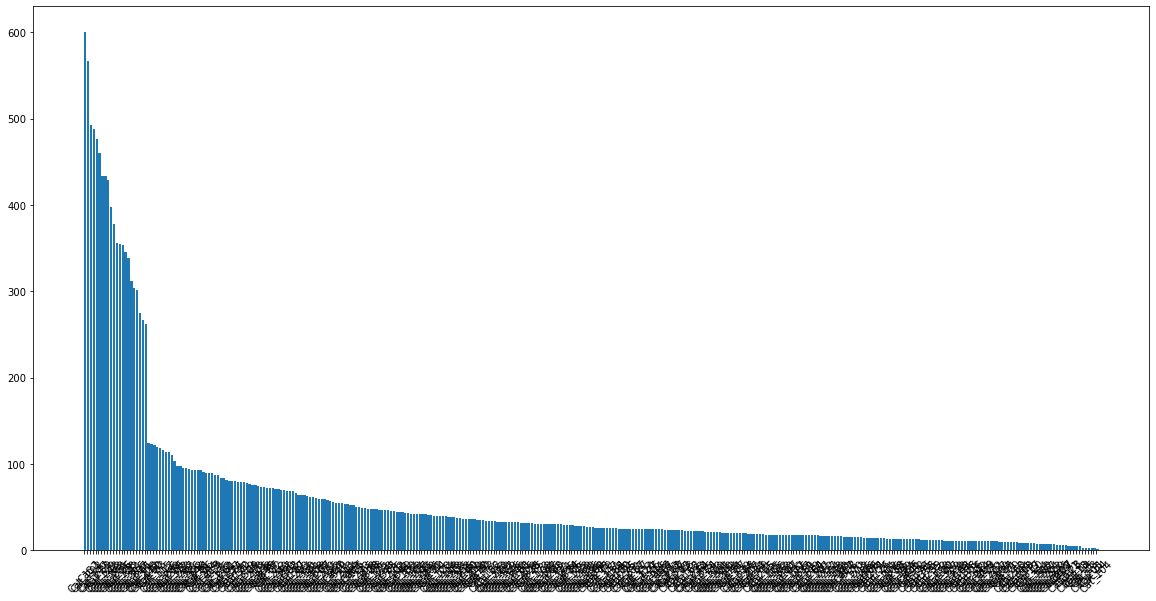

In [21]:
plt.figure(figsize=(20,10))
plt.bar(x = a.keys(), height = a.values, align='edge')
plt.xticks(rotation = 45);

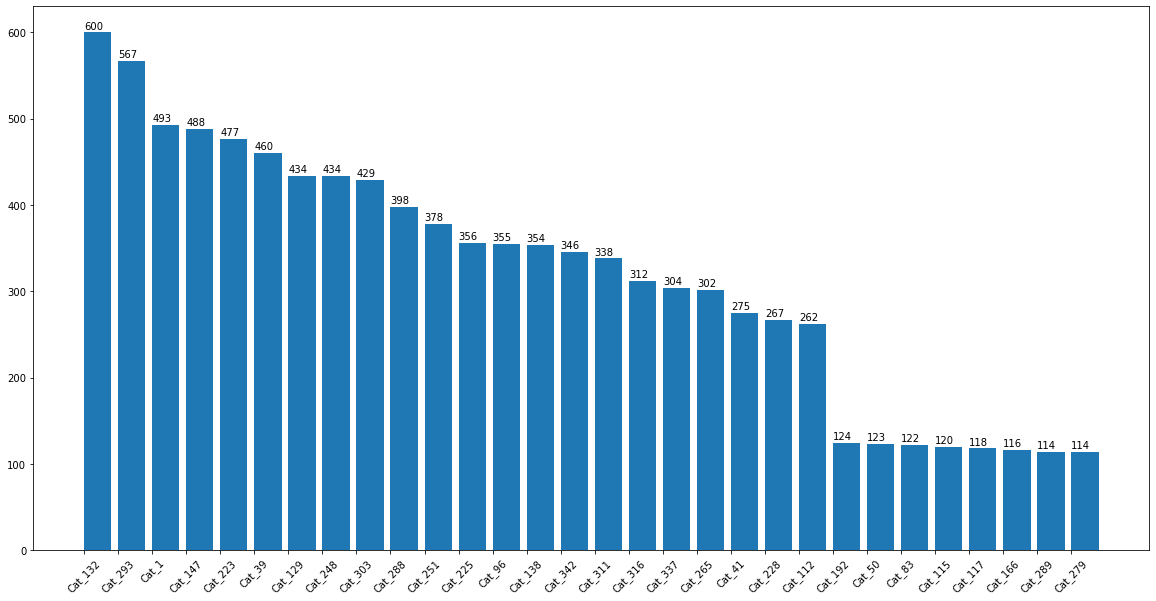

In [22]:
b=a[:30]
plt.figure(figsize=(20,10))
plt.bar(x = b.keys(), height = b.values, align='edge')
#xx=b.keys()+np.ones(len))
yy=b.values+np.ones(len(b.values))*4
for i, txt in enumerate(b.values):
    plt.annotate(str(txt), (b.keys()[i],yy[i]))
plt.xticks(rotation = 45);
plt.show()

In [31]:
cat5= b[:5]
print(cat5)

Cat_132    600
Cat_293    567
Cat_1      493
Cat_147    488
Cat_223    477
Name: Intencion, dtype: int64


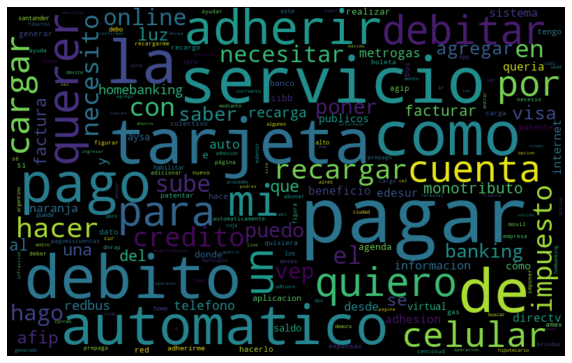

In [52]:
Cat_132= data2[data2["Intencion"] == "Cat_132"]
palabras = ' '.join([text for text in Cat_132.Pregunta])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(palabras)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


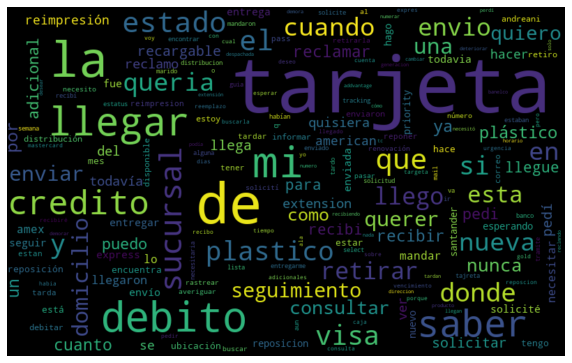

In [51]:
Cat_293= data2[data2["Intencion"] == "Cat_293"]
palabras = ' '.join([text for text in Cat_293.Pregunta])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(palabras)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

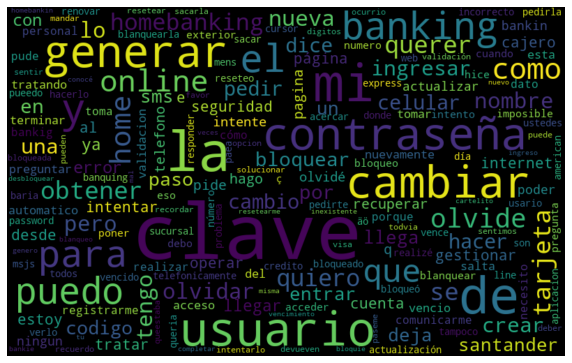

In [53]:
Cat_1= data2[data2["Intencion"] == "Cat_1"]
palabras = ' '.join([text for text in Cat_1.Pregunta])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(palabras)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

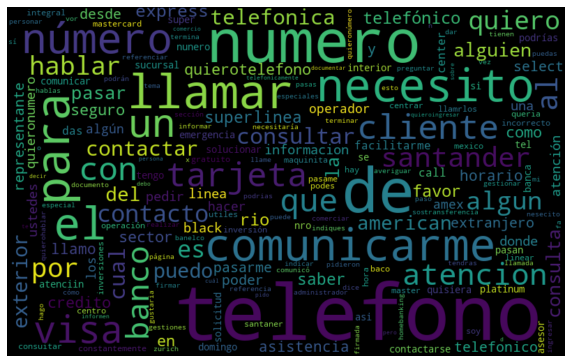

In [54]:
Cat_147= data2[data2["Intencion"] == "Cat_147"]
palabras = ' '.join([text for text in Cat_147.Pregunta])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(palabras)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

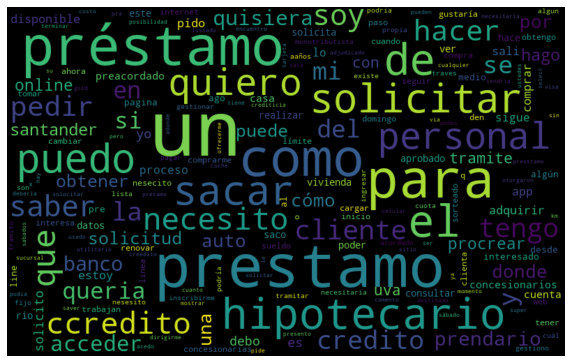

In [55]:
Cat_223= data2[data2["Intencion"] == "Cat_223"]
palabras = ' '.join([text for text in Cat_223.Pregunta])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(palabras)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
# Modificar para que solo tome la palabra que se le pasa. Palabras a corregir al hacer eso: 
# "acer", "abil", "ago", "ai", "par" (para), 

def reemplazar(df, a_reemplazar, reemplazar_por):
    """
    a_reemplazar: string que se quiere modificar
    reemplazar_por: nuevo string
    """
    msk_contains = df["Pregunta_corregida"].apply(lambda x: True if a_reemplazar in x else False)
    print(f"Cantidad encontrada: {msk_contains.sum()}")
    df.loc[msk_contains, "Pregunta_corregida"] = df.loc[msk_contains, "Pregunta_corregida"].apply(lambda x: re.sub(a_reemplazar, reemplazar_por, x))
    return df

In [26]:
data2 = reemplazar(data2, "aadvantag", "advantage")
data2 = reemplazar(data2, "xq", "porque")
data2 = reemplazar(data2, "abir", "abrir")
data2 = reemplazar(data2, "agip", "afip")
data2 = reemplazar(data2, "acseder", "acceder")
data2 = reemplazar(data2, "aderirme", "adherirme")
data2 = reemplazar(data2, "ccredito", "crédito")
data2 = reemplazar(data2, "banquin", "banking")
data2 = reemplazar(data2, "conumo", "consumo")

Cantidad encontrada: 0
Cantidad encontrada: 0
Cantidad encontrada: 0
Cantidad encontrada: 0
Cantidad encontrada: 0
Cantidad encontrada: 0
Cantidad encontrada: 2
Cantidad encontrada: 4
Cantidad encontrada: 0


# Stemming

In [24]:
stemmer = SnowballStemmer('spanish')

In [25]:
# Defimimos una función que aplica stemming a una frase en castellano:
def stemfraseesp(frase):    
    token_words=word_tokenize(frase)
    token_words
    stem_sentence=[]    
    spanishStemmer=SnowballStemmer("spanish",ignore_stopwords=True)
    for word in token_words:
        stem_sentence.append(spanishStemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [26]:
data2["Pregunta_stem"] = data2["Pregunta_corregida"].apply(lambda x: stemfraseesp(x))
data2.head()

,Pregunta,Intencion,Pregunta_new,Pregunta_corregida,Pregunta_stem
2,pagar tarjeta naranja sistema,Cat_132,pagar tarjeta naranja sistema,pagar tarjeta naranja sistema,pag tarjet naranj sistem
3,no se debitó la primera cuota del plan de bien...,Cat_129,no se debitó la primera cuota del plan de bien...,no se debito la primera cuota del plan de bien...,no se debit la primer cuot del plan de bien pe...
4,abonar tarjeta credito,Cat_342,abonar tarjeta credito,abonar tarjeta credito,abon tarjet credit
5,se puede pagar la mastercard desde uno de los ...,Cat_342,se puede pagar la mastercard desde uno de los ...,se puede pagar la mastercard desde uno de los ...,se pued pag la mastercard desde uno de los aut...
7,pasar preguntar seguridad,Cat_1,pasar preguntar seguridad,pasar preguntar seguridad,pas pregunt segur


# Separacion dataframe

In [27]:
Train,Test=train_test_split(data2,stratify=data2["Intencion"],test_size=0.25,random_state=717);

Train.reset_index(drop=True,inplace=True);
Test.reset_index(drop=True,inplace=True);
Train.head(3)

,Pregunta,Intencion,Pregunta_new,Pregunta_corregida,Pregunta_stem
0,pagar deudaque refinanciada,Cat_192,pagar deudaque refinanciada,pagar destaque refinanciada,pag destaqu refinanci
1,vencer debito automatico cable vision informar...,Cat_129,vencer debito automatico cable vision informar...,vencer debito automatico cable vision informar...,venc debit automat cabl vision inform rechaz d...
2,queria abrirme caja ahorro,Cat_39,queria abrirme caja ahorro,quera abrirme caja ahorro,quer abrirm caj ahorr


In [28]:
intenciones = Train["Intencion"].value_counts()

df_train = pd.DataFrame(columns = Train.columns)

muestras = 450

for k in intenciones.keys():
    if intenciones[k] <= muestras:
        df_aux = Train[Train["Intencion"] == k].sample(muestras, replace = True)
    else:
        df_aux = Train[Train["Intencion"] == k]
    df_train = df_train.append(df_aux)

print("Tamaño train", Train.shape)
print("Tamaño train oversampleado", df_train.shape)

Tamaño train (7344, 5)
Tamaño train oversampleado (14400, 5)


In [29]:
Train["Intencion"].value_counts(normalize = True)

Cat_132    0.061275
Cat_293    0.057870
Cat_1      0.050381
Cat_147    0.049837
Cat_223    0.048747
Cat_39     0.046977
Cat_248    0.044254
Cat_129    0.044254
Cat_303    0.043845
Cat_288    0.040577
Cat_251    0.038535
Cat_225    0.036356
Cat_96     0.036220
Cat_138    0.036084
Cat_342    0.035267
Cat_311    0.034450
Cat_316    0.031863
Cat_337    0.031046
Cat_265    0.030910
Cat_41     0.028050
Cat_228    0.027233
Cat_112    0.026825
Cat_192    0.012663
Cat_83     0.012527
Cat_50     0.012527
Cat_115    0.012255
Cat_117    0.012119
Cat_166    0.011846
Cat_289    0.011710
Cat_279    0.011710
Cat_56     0.011302
Cat_312    0.010485
Name: Intencion, dtype: float64

In [30]:
df_train["Intencion"].value_counts(normalize = True)

Cat_279    0.03125
Cat_248    0.03125
Cat_138    0.03125
Cat_129    0.03125
Cat_117    0.03125
Cat_293    0.03125
Cat_312    0.03125
Cat_112    0.03125
Cat_166    0.03125
Cat_132    0.03125
Cat_342    0.03125
Cat_228    0.03125
Cat_223    0.03125
Cat_115    0.03125
Cat_56     0.03125
Cat_147    0.03125
Cat_83     0.03125
Cat_96     0.03125
Cat_265    0.03125
Cat_337    0.03125
Cat_251    0.03125
Cat_39     0.03125
Cat_303    0.03125
Cat_316    0.03125
Cat_289    0.03125
Cat_225    0.03125
Cat_41     0.03125
Cat_1      0.03125
Cat_192    0.03125
Cat_311    0.03125
Cat_288    0.03125
Cat_50     0.03125
Name: Intencion, dtype: float64

In [31]:
x_train = df_train['Pregunta_corregida']
y_train = df_train['Intencion']

x_train_stem = df_train['Pregunta_stem']
y_train = df_train['Intencion']

x_test = Test['Pregunta_corregida']
y_test = Test['Intencion']

# Separación en train y test

In [26]:
X = data2['Pregunta_corregida']
y = data2['Intencion']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=717,stratify=y)

In [27]:
X_stem = data2['Pregunta_stem']
y_stem = data2['Intencion']

x_train_stem, x_test_stem, y_train, y_test = train_test_split(X_stem, y_stem, test_size=0.25, random_state=717,stratify=y)

# Modelos de text mining

## 1° Probamos con CountVectorizer los modelos de Naive Bayes Multinomial y Regresion Logistica

In [28]:
vectorizer = CountVectorizer(strip_accents='unicode');
X_train = vectorizer.fit_transform(x_train);
X_test = vectorizer.transform(x_test);
print('Dimensionalidad del dataset:')
X_train.shape
skf=StratifiedKFold(n_splits=3,random_state=0,shuffle=True);

Dimensionalidad del dataset:


#### Naive Bayes Multinomial

In [29]:
params={'alpha':np.arange(0.001,1,0.005)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=-1);
GS_CV.fit(X_train,y_train);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

best_model=GS_CV.best_estimator_;

print('\nTest set:\n')

test_pred=best_model.predict(X_test);

print('accuracy:',accuracy_score(y_test,test_pred))

print('\nconfusion:\n',confusion_matrix(y_test,test_pred))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    5.6s finished


best score: 0.8636982570806101
best params: {'alpha': 0.066}

Test set:

accuracy: 0.9020008166598612

confusion:
 [[114   0   0 ...   0   0   0]
 [  0  45   4 ...   0   0   1]
 [  0   2  18 ...   0   0   2]
 ...
 [  0   0   2 ...  23   0   0]
 [  0   0   0 ...   0  27   0]
 [  0   0   0 ...   0   0  87]]


#### Regresion Logistica

In [30]:
param_grid = {'C':[1]};
GS_CV = GridSearchCV(LogisticRegression(), param_grid, cv=skf,verbose=1,n_jobs=-1);
GS_CV.fit(X_train,y_train);

print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

best_model=GS_CV.best_estimator_;

print('\nTest set:\n')

test_pred=best_model.predict(X_test);

print('accuracy:',accuracy_score(y_test,test_pred))

print('\nconfusion:\n',confusion_matrix(y_test,test_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


best score: 0.8711873638344226
best params: {'C': 1}

Test set:

accuracy: 0.9032258064516129

confusion:
 [[117   0   0 ...   0   0   0]
 [  0  50   2 ...   0   0   0]
 [  0   4  16 ...   0   0   1]
 ...
 [  0   0   0 ...  24   0   0]
 [  0   0   0 ...   0  26   1]
 [  0   0   0 ...   0   0  85]]


## 2° Probamos con CountVectorizer eliminando las Stopwords con los modelos de Naive Bayes Multinomial y Regresion Logistica

In [31]:
stopwords_sp = stopwords.words("spanish")

vectorizer = CountVectorizer(strip_accents='unicode', stop_words = stopwords_sp);
X_train_sw = vectorizer.fit_transform(x_train);
X_test_sw = vectorizer.transform(x_test);
print('Dimensionalidad del dataset:')
print(f"Shape de X_train: {X_train_sw.shape}")
skf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True);

Dimensionalidad del dataset:
Shape de X_train: (7344, 2494)


C:\Users\rodri\.conda\envs\dhdsblend\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', '

#### Naive Bayes Multinomial

In [32]:
params = {'alpha':np.arange(0.001,1,0.005)};
GS_CV = GridSearchCV(MultinomialNB(), params, cv = skf, verbose = 1, n_jobs = -1);
GS_CV.fit(X_train_sw,y_train);
print('best score:', GS_CV.best_score_)
print('best params:', GS_CV.best_params_)

best_model = GS_CV.best_estimator_;

print('\nTest set:\n')

test_pred = best_model.predict(X_test_sw);

print('accuracy:',accuracy_score(y_test,test_pred))

print('\nconfusion:\n',confusion_matrix(y_test,test_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s


best score: 0.8534858387799563
best params: {'alpha': 0.046}

Test set:

accuracy: 0.893834218048183

confusion:
 [[116   0   0 ...   0   0   0]
 [  0  42   2 ...   1   0   2]
 [  0   4  17 ...   0   0   3]
 ...
 [  0   0   0 ...  24   0   0]
 [  0   0   0 ...   0  27   0]
 [  0   0   0 ...   0   0  86]]


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.4s finished


#### Regresion Logistica

In [33]:
param_grid = {'C':[1]};
GS_CV = GridSearchCV(LogisticRegression(), param_grid, cv=skf,verbose=1,n_jobs=-1);
GS_CV.fit(X_train_sw,y_train);
print('best score:', GS_CV.best_score_)
print('best params:', GS_CV.best_params_)

best_model = GS_CV.best_estimator_;

print('\nTest set:\n')

test_pred = best_model.predict(X_test_sw);

print('accuracy:',accuracy_score(y_test,test_pred))

print('\nconfusion:\n',confusion_matrix(y_test,test_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


best score: 0.8502178649237472
best params: {'C': 1}

Test set:

accuracy: 0.8926092282564312

confusion:
 [[118   0   0 ...   0   0   0]
 [  0  47   3 ...   0   0   2]
 [  0   6  13 ...   0   0   2]
 ...
 [  0   0   0 ...  25   0   0]
 [  0   1   0 ...   0  27   0]
 [  0   0   0 ...   0   0  85]]


## 3° Probamos con TF-IDF con los modelos de Naive Bayes Multinomial y Regresion Logistica

In [34]:
Tfidf_encoding = TfidfTransformer()

In [35]:
tfidf = TfidfTransformer();
X_train_tfidf = tfidf.fit_transform(X_train);
X_test_tfidf = tfidf.transform(X_test);
skf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True);

#### Naive Bayes Multinomial

In [36]:
param_grid = {'alpha':np.arange(0.001,1,0.005)};
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf,verbose=1,n_jobs=-1);
grid.fit(X_train_tfidf, y_train);

print("Best cross-validation score: {:.4f}".format(grid.best_score_));
print("Best parameters: ", grid.best_params_);
print("Test score: ", grid.score(X_test_tfidf, y_test))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s


Best cross-validation score: 0.8563
Best parameters:  {'alpha': 0.016}
Test score:  0.8958758677011025


[Parallel(n_jobs=-1)]: Done 585 out of 600 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.5s finished


#### Regresion Logistica

In [37]:
param_grid = {'C':[1]};
grid = GridSearchCV(LogisticRegression(), param_grid, cv=skf,verbose=1,n_jobs=-1);
grid.fit(X_train_tfidf, y_train);

print("Best cross-validation score: {:.4f}".format(grid.best_score_));
print("Best parameters: ", grid.best_params_);
print("Test score: ", grid.score(X_test_tfidf, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Best cross-validation score: 0.8468
Best parameters:  {'C': 1}
Test score:  0.8762760310330747


## 4° Probamos con TF-IDF + Steam con los modelos de Naive Bayes Multinomial y Regresion Logistica

In [38]:
stopwords_sp = stopwords.words("spanish")

vectorizer = CountVectorizer(strip_accents='unicode', stop_words = stopwords_sp);
X_train_stem_sw = vectorizer.fit_transform(x_train_stem);
X_test_stem_sw = vectorizer.transform(x_test_stem);

tfidf = TfidfTransformer();
X_tfidf = tfidf.fit_transform(X_train_stem_sw);
X_test_tfidf = tfidf.transform(X_test_stem_sw);

skf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True);

C:\Users\rodri\.conda\envs\dhdsblend\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', '

#### Naive Bayes Multinomial

In [39]:
param_grid = {'alpha':np.arange(0.001,1,0.005)};
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf,verbose=1,n_jobs=-1);
grid.fit(X_tfidf, y_train);

print("Best cross-validation score: {:.4f}".format(grid.best_score_));
print("Best parameters: ", grid.best_params_);
print("Test score: ", grid.score(X_test_tfidf, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s


Best cross-validation score: 0.8501
Best parameters:  {'alpha': 0.036000000000000004}
Test score:  0.8766843609636586


[Parallel(n_jobs=-1)]: Done 585 out of 600 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.2s finished


#### Regresion Logistica

In [40]:
param_grid = {'C':[1]};
grid = GridSearchCV(LogisticRegression(), param_grid, cv=skf,verbose=1,n_jobs=-1);
grid.fit(X_tfidf, y_train);

print("Best cross-validation score: {:.4f}".format(grid.best_score_));
print("Best parameters: ", grid.best_params_);
print("Test score: ", grid.score(X_test_tfidf, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Best cross-validation score: 0.8449
Best parameters:  {'C': 1}
Test score:  0.8721927317272357


## 5° Probamos RandomForest

In [41]:
param_grid = {
    'n_estimators':np.arange(108, 110), 
    "max_depth": np.arange(158, 160)
};

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=skf,verbose=1, n_jobs=-1);
grid.fit(X_tfidf, y_train);

print("Best cross-validation score: {:.4f}".format(grid.best_score_));
print("Best parameters: ", grid.best_params_);

print("Test score: ", grid.score(X_test_tfidf, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    9.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    9.3s finished


Best cross-validation score: 0.8709
Best parameters:  {'max_depth': 159, 'n_estimators': 109}
Test score:  0.902817476521029
